**Working with the dataset containing the single_trial files**

Includes experiments ran with both a 1D-CNN and LSTM model on the new dataset (single_trial_files and not dat_files). Data was scaled in some instances to help remove unwanted noise. Both K Fold and Group K Fold cross validations were ran with each of the models.

**Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Load Data**

In [ ]:
%cd drive/My \Drive/
%run LoadData.ipynb

**Imports**

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt     
import tensorflow as tf
import sklearn.linear_model
from tensorflow import keras
from keras import Sequential, layers
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler, Normalizer

**Visualization Functions**

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
#for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    diff = cm.max() - cm.min()
    thresh = cm.min() + (diff/2.)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            fontsize='xx-large',
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#helper function for plotting graphs of our results
def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

**Create Models**

In [ ]:
#creates 1D-CNN Model
def create_cnn_model():
  #variables to be used for input shape
  ROWS = 1101
  COLS = 64

  model = Sequential()
  #add 1D Convolution Layers
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(ROWS, COLS)))
  model.add(MaxPooling1D(pool_size=2))

  model.add(Dropout(0.2))
  
  model.add(Conv1D(filters=64, kernel_size=5, activation='relu', name='Layer2')) 
  model.add(MaxPooling1D(pool_size=2))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  #compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

  return model

In [ ]:
#Creates LSTM Model
def create_lstm_model():
  #variables to be used for input shape
  ROWS = 1101
  COLS = 64
  
  #Double Bidirectional LSTM layer model
  model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', name='first_dense'),
    tf.keras.layers.Dense(64, activation='relu', name='2nd_dense'),
    tf.keras.layers.Dense(1)
  ])
  #compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
  
  return model

**Normalization with scaling**

In [ ]:
# Scale data
for i in range(static_trials.shape[0]):
    scaler = StandardScaler()
    static_trials[i, :, :] = scaler.fit_transform(static_trials[i, :, :]) 

static_trials.shape

(2876, 1101, 64)

In [ ]:
#dynamic files
for i in range(dyn_trials.shape[0]):
    scaler = StandardScaler()
    dyn_trials[i, :, :] = scaler.fit_transform(dyn_trials[i, :, :]) 

dyn_trials.shape

(2824, 1101, 64)

**K fold with CNN (no groups)**

Train on 2300 samples, validate on 576 samples
Epoch 1/25
 - 14s - loss: 0.8578 - accuracy: 0.5030 - val_loss: 0.6933 - val_accuracy: 0.4931
Epoch 2/25
 - 13s - loss: 0.6898 - accuracy: 0.5117 - val_loss: 0.6941 - val_accuracy: 0.4861
Epoch 3/25
 - 13s - loss: 0.6791 - accuracy: 0.5600 - val_loss: 0.6988 - val_accuracy: 0.4948
Epoch 4/25
 - 13s - loss: 0.6504 - accuracy: 0.6300 - val_loss: 0.6966 - val_accuracy: 0.5017
Epoch 5/25
 - 14s - loss: 0.5976 - accuracy: 0.6778 - val_loss: 0.7433 - val_accuracy: 0.4948
Epoch 6/25
 - 13s - loss: 0.5283 - accuracy: 0.7348 - val_loss: 0.7805 - val_accuracy: 0.5226
Epoch 7/25
 - 13s - loss: 0.4504 - accuracy: 0.7939 - val_loss: 0.8900 - val_accuracy: 0.4965
Epoch 8/25
 - 13s - loss: 0.3529 - accuracy: 0.8491 - val_loss: 0.9576 - val_accuracy: 0.4983
Epoch 9/25
 - 13s - loss: 0.2754 - accuracy: 0.8848 - val_loss: 1.0335 - val_accuracy: 0.5451
Epoch 10/25
 - 14s - loss: 0.2178 - accuracy: 0.9100 - val_loss: 1.1986 - val_accuracy: 0.5139
Epoch 11/25


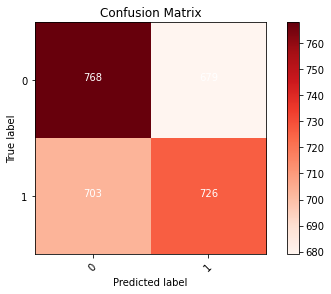

In [ ]:
#static files
n_epochs = 25
n_splits = 5
batch_size = 32
verbose = 2

class_names = [0, 1]

accuracies = []
losses = []
splits = []

predicts = []
trues = []

split_no = 1

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

for train_index, test_index in kfold.split(static_trials):
  #split data into X and y training and test sets
  static_X_train, static_X_test = static_trials[train_index], static_trials[test_index]
  static_y_train, static_y_test = static_labels[train_index], static_labels[test_index]

  #build model
  model = create_cnn_model() 
  
  #fit model
  history = model.fit(static_X_train, static_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(static_X_test, static_y_test))
  
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = static_y_test
  y_pred_prob = model.predict(static_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)

  #evaluate model
  loss, accuracy = model.evaluate(static_X_test, static_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  splits.append("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
for x in range(0, n_splits):
  print(splits[x])
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

#print graphs to see best parameter values
#plot_metrics(history, 'loss')
#plot_metrics(history, 'accuracy')

Train on 2259 samples, validate on 565 samples
Epoch 1/25
 - 12s - loss: 0.8010 - accuracy: 0.5051 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 2/25
 - 12s - loss: 0.6922 - accuracy: 0.5131 - val_loss: 0.6927 - val_accuracy: 0.5487
Epoch 3/25
 - 12s - loss: 0.6883 - accuracy: 0.5361 - val_loss: 0.6924 - val_accuracy: 0.5345
Epoch 4/25
 - 12s - loss: 0.6772 - accuracy: 0.5764 - val_loss: 0.7004 - val_accuracy: 0.5434
Epoch 5/25
 - 12s - loss: 0.6482 - accuracy: 0.6104 - val_loss: 0.7150 - val_accuracy: 0.5239
Epoch 6/25
 - 12s - loss: 0.6030 - accuracy: 0.6786 - val_loss: 0.7378 - val_accuracy: 0.5186
Epoch 7/25
 - 12s - loss: 0.5337 - accuracy: 0.7322 - val_loss: 0.7584 - val_accuracy: 0.5345
Epoch 8/25
 - 12s - loss: 0.4325 - accuracy: 0.7990 - val_loss: 0.9106 - val_accuracy: 0.5239
Epoch 9/25
 - 12s - loss: 0.3431 - accuracy: 0.8473 - val_loss: 1.0006 - val_accuracy: 0.5274
Epoch 10/25
 - 12s - loss: 0.2651 - accuracy: 0.8876 - val_loss: 1.1026 - val_accuracy: 0.5504
Epoch 11/25


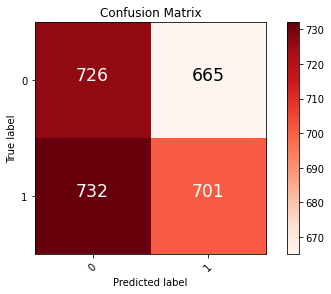

In [ ]:
#dynamic files
n_epochs = 25
n_splits = 5
batch_size = 32
verbose = 2

class_names = [0, 1]

accuracies = []
losses = []

predicts = []
trues = []

split_no = 1

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

for train_index, test_index in kfold.split(dyn_trials):
  #split data into X and y training and test sets
  dyn_X_train, dyn_X_test = dyn_trials[train_index], dyn_trials[test_index]
  dyn_y_train, dyn_y_test = dyn_labels[train_index], dyn_labels[test_index]

  #build model
  model = create_cnn_model()
  
  #fit model
  history = model.fit(dyn_X_train, dyn_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(dyn_X_test, dyn_y_test))
  
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = dyn_y_test
  y_pred_prob = model.predict(dyn_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)

  #evaluate model
  loss, accuracy = model.evaluate(dyn_X_test, dyn_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

#print graphs to see best parameter values
#plot_metrics(history, 'loss')
#plot_metrics(history, 'accuracy')

**Group K fold cross validation with CNN**

Train on 2109 samples, validate on 767 samples
Epoch 1/15
 - 7s - loss: 2.4040 - accuracy: 0.5002 - val_loss: 0.6980 - val_accuracy: 0.4798
Epoch 2/15
 - 7s - loss: 0.6848 - accuracy: 0.5543 - val_loss: 0.6979 - val_accuracy: 0.4980
Epoch 3/15
 - 7s - loss: 0.6614 - accuracy: 0.6074 - val_loss: 0.6979 - val_accuracy: 0.5007
Epoch 4/15
 - 7s - loss: 0.6323 - accuracy: 0.6339 - val_loss: 0.7192 - val_accuracy: 0.4967
Epoch 5/15
 - 7s - loss: 0.5953 - accuracy: 0.6591 - val_loss: 0.7259 - val_accuracy: 0.5137
Epoch 6/15
 - 7s - loss: 0.5392 - accuracy: 0.7160 - val_loss: 0.7741 - val_accuracy: 0.5189
Epoch 7/15
 - 7s - loss: 0.4717 - accuracy: 0.7700 - val_loss: 0.8405 - val_accuracy: 0.4967
Epoch 8/15
 - 7s - loss: 0.4394 - accuracy: 0.7885 - val_loss: 0.8260 - val_accuracy: 0.5176
Epoch 9/15
 - 7s - loss: 0.4215 - accuracy: 0.7828 - val_loss: 0.9338 - val_accuracy: 0.4915
Epoch 10/15
 - 7s - loss: 0.3580 - accuracy: 0.8321 - val_loss: 1.0690 - val_accuracy: 0.4863
Epoch 11/15
 - 7s - lo

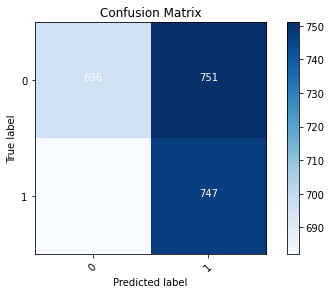

In [ ]:
#static files
n_epochs = 15
n_splits = 4
batch_size = 32
verbose = 2

class_names = [0, 1]

accuracies = []
losses = []

predicts = []
trues = []

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(static_trials, static_labels, static_groups):
  #split data into X and y training and test sets
  static_X_train, static_X_test = static_trials[train_index], static_trials[test_index]
  static_y_train, static_y_test = static_labels[train_index], static_labels[test_index]

  #build model
  model = create_cnn_model()
  
  #fit model
  history = model.fit(static_X_train, static_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(static_X_test, static_y_test))
  
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = static_y_test
  y_pred_prob = model.predict(static_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)
  '''
  print("Training group labels: ", static_groups[train_index])
  print("Testing group labels: ", static_groups[test_index])
  print("True labels: ", y_true)
  print("Pred labels: ", y_pred)
  print ("\n")
  '''
  #evaluate model
  loss, accuracy = model.evaluate(static_X_test, static_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

#print graphs to see best parameter values
#plot_metrics(history, 'loss')
#plot_metrics(history, 'accuracy')

Train on 2106 samples, validate on 718 samples
Epoch 1/25
 - 17s - loss: 2.3085 - accuracy: 0.5237 - val_loss: 1.9939 - val_accuracy: 0.4331
Epoch 2/25
 - 16s - loss: 0.6631 - accuracy: 0.5859 - val_loss: 2.9161 - val_accuracy: 0.4095
Epoch 3/25
 - 16s - loss: 0.6473 - accuracy: 0.6178 - val_loss: 3.6010 - val_accuracy: 0.3886
Epoch 4/25
 - 16s - loss: 0.5985 - accuracy: 0.6724 - val_loss: 3.5661 - val_accuracy: 0.3914
Epoch 5/25
 - 16s - loss: 0.5360 - accuracy: 0.7146 - val_loss: 4.6011 - val_accuracy: 0.3747
Epoch 6/25
 - 16s - loss: 0.4493 - accuracy: 0.7792 - val_loss: 5.5223 - val_accuracy: 0.3872
Epoch 7/25
 - 16s - loss: 0.3504 - accuracy: 0.8509 - val_loss: 8.2854 - val_accuracy: 0.3649
Epoch 8/25
 - 16s - loss: 0.3042 - accuracy: 0.8647 - val_loss: 15.1849 - val_accuracy: 0.3844
Epoch 9/25
 - 16s - loss: 0.2517 - accuracy: 0.8970 - val_loss: 15.8447 - val_accuracy: 0.3705
Epoch 10/25
 - 16s - loss: 0.2168 - accuracy: 0.9188 - val_loss: 15.4659 - val_accuracy: 0.3733
Epoch 11/

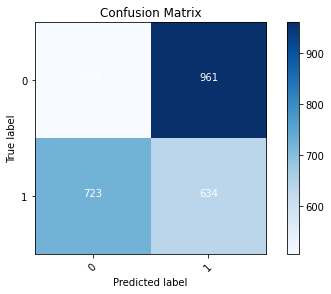

In [ ]:
#dynamic files
n_epochs = 25
n_splits = 4
batch_size = 50
verbose = 2

class_names = [0, 1]

accuracies = []
losses = []

predicts = []
trues = []

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(dyn_trials, dyn_labels, dyn_groups):
  #split data into X and y training and test sets
  dyn_X_train, dyn_X_test = dyn_trials[train_index], dyn_trials[test_index]
  dyn_y_train, dyn_y_test = dyn_labels[train_index], dyn_labels[test_index]

  #build model
  model = create_cnn_model()
  
  #fit model
  history = model.fit(dyn_X_train, dyn_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(dyn_X_test, dyn_y_test))
  
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = dyn_y_test
  y_pred_prob = model.predict(dyn_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)
  '''
  print("Training group labels: ", dyn_groups[train_index])
  print("Testing group labels: ", dyn_groups[test_index])
  print("True labels: ", y_true)
  print("Pred labels: ", y_pred)
  print ("\n")
  '''
  #evaluate model
  loss, accuracy = model.evaluate(dyn_X_test, dyn_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

#print graphs to see best parameter values
#plot_metrics(history, 'loss')
#plot_metrics(history, 'accuracy')

**K fold with LSTM**

In [ ]:
#static files
n_epochs = 15
n_splits = 4
batch_size = 32
verbose = 2

class_names = [0, 1]

accuracies = []
losses = []

predicts = []
trues = []

split_no = 1

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

for train_index, test_index in kfold.split(static_trials):
  #split data into X and y training and test sets
  static_X_train, static_X_test = static_trials[train_index], static_trials[test_index]
  static_y_train, static_y_test = static_labels[train_index], static_labels[test_index]

  #build model
  model = create_lstm_model()
  
  #fit model
  history = model.fit(static_X_train, static_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(static_X_test, static_y_test))
  
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = static_y_test
  y_pred_prob = model.predict(static_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)
  '''
  print("Training group labels: ", static_groups[train_index])
  print("Testing group labels: ", static_groups[test_index])
  print("True labels: ", y_true)
  print("Pred labels: ", y_pred)
  print ("\n")
  '''
  #evaluate model
  loss, accuracy = model.evaluate(static_X_test, static_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

#print graphs to see best parameter values
plot_metrics(history, 'loss')
plot_metrics(history, 'accuracy')

In [ ]:
#dynamic files
n_epochs = 15
n_splits = 4
batch_size = 50
verbose = 2

class_names = [0, 1]

accuracies = []
losses = []

predicts = []
trues = []

split_no = 1

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=None)

for train_index, test_index in kfold.split(dyn_trials):
  #split data into X and y training and test sets
  dyn_X_train, dyn_X_test = dyn_trials[train_index], dyn_trials[test_index]
  dyn_y_train, dyn_y_test = dyn_labels[train_index], dyn_labels[test_index]

  #build model
  model = create_lstm_model()
  
  #fit model
  history = model.fit(dyn_X_train, dyn_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(dyn_X_test, dyn_y_test))
  
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = dyn_y_test
  y_pred_prob = model.predict(dyn_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)
  
  #evaluate model
  loss, accuracy = model.evaluate(dyn_X_test, dyn_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

#print graphs to see best parameter values
plot_metrics(history, 'loss')
plot_metrics(history, 'accuracy')

**Group K fold cross validation with LSTM**

In [ ]:
#static files
n_epochs = 15
n_splits = 4
batch_size = 25 
verbose = 2

class_names = [0, 1]

accuracies = []
losses = []

predicts = []
trues = []

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(static_trials, static_labels, static_groups):
  #split data into X and y training and test sets
  static_X_train, static_X_test = static_trials[train_index], static_trials[test_index]
  static_y_train, static_y_test = static_labels[train_index], static_labels[test_index]

  #build model
  model = create_lstm_model()
  
  #fit model
  history = model.fit(static_X_train, static_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(static_X_test, static_y_test))
  
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = static_y_test
  y_pred_prob = model.predict(static_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)
  '''
  print("Training group labels: ", static_groups[train_index])
  print("Testing group labels: ", static_groups[test_index])
  print("True labels: ", y_true)
  print("Pred labels: ", y_pred)
  print ("\n")
  '''
  #evaluate model
  loss, accuracy = model.evaluate(static_X_test, static_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

#print graphs to see best parameter values
plot_metrics(history, 'loss')
plot_metrics(history, 'accuracy')

Epoch 1/15
85/85 - 163s - loss: 0.7030 - accuracy: 0.5050 - val_loss: 0.6965 - val_accuracy: 0.5163
Epoch 2/15
85/85 - 166s - loss: 0.6831 - accuracy: 0.5121 - val_loss: 0.6956 - val_accuracy: 0.5176
Epoch 3/15
85/85 - 163s - loss: 0.6700 - accuracy: 0.5154 - val_loss: 0.6964 - val_accuracy: 0.5150
Epoch 4/15
85/85 - 163s - loss: 0.6578 - accuracy: 0.5202 - val_loss: 0.6964 - val_accuracy: 0.5163
Epoch 5/15
85/85 - 162s - loss: 0.6457 - accuracy: 0.5306 - val_loss: 0.6984 - val_accuracy: 0.5163
Epoch 6/15
85/85 - 164s - loss: 0.6324 - accuracy: 0.5500 - val_loss: 0.7002 - val_accuracy: 0.5137
Epoch 7/15
85/85 - 166s - loss: 0.6175 - accuracy: 0.5723 - val_loss: 0.7039 - val_accuracy: 0.5124
Epoch 8/15
85/85 - 164s - loss: 0.5991 - accuracy: 0.6064 - val_loss: 0.7071 - val_accuracy: 0.5137
Epoch 9/15
85/85 - 164s - loss: 0.5781 - accuracy: 0.6415 - val_loss: 0.7122 - val_accuracy: 0.5254
Epoch 10/15
85/85 - 165s - loss: 0.5537 - accuracy: 0.6823 - val_loss: 0.7199 - val_accuracy: 0.5332

Train on 2106 samples, validate on 718 samples
Epoch 1/15
 - 15s - loss: 3.9610 - accuracy: 0.5123 - val_loss: 0.7900 - val_accuracy: 0.4596
Epoch 2/15
 - 14s - loss: 0.6633 - accuracy: 0.5954 - val_loss: 1.1191 - val_accuracy: 0.4345
Epoch 3/15
 - 15s - loss: 0.6316 - accuracy: 0.6429 - val_loss: 1.3565 - val_accuracy: 0.3621
Epoch 4/15
 - 14s - loss: 0.5571 - accuracy: 0.7289 - val_loss: 1.9290 - val_accuracy: 0.3649
Epoch 5/15
 - 14s - loss: 0.4457 - accuracy: 0.7939 - val_loss: 2.5560 - val_accuracy: 0.3398
Epoch 6/15
 - 14s - loss: 0.3513 - accuracy: 0.8405 - val_loss: 3.2475 - val_accuracy: 0.3440
Epoch 7/15
 - 14s - loss: 0.2793 - accuracy: 0.8889 - val_loss: 3.7296 - val_accuracy: 0.3552
Epoch 8/15
 - 14s - loss: 0.2142 - accuracy: 0.9164 - val_loss: 4.5744 - val_accuracy: 0.3412
Epoch 9/15
 - 14s - loss: 0.1487 - accuracy: 0.9449 - val_loss: 5.3392 - val_accuracy: 0.3398
Epoch 10/15
 - 15s - loss: 0.1979 - accuracy: 0.9245 - val_loss: 4.9937 - val_accuracy: 0.3426
Epoch 11/15


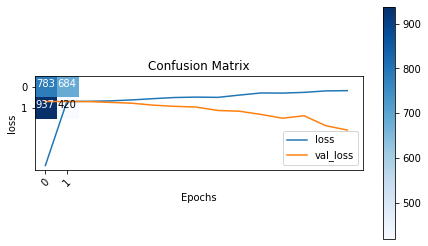

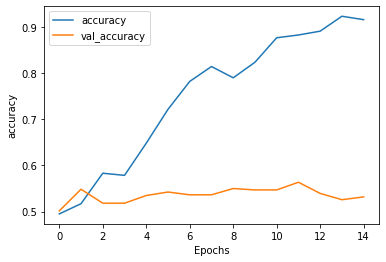

In [ ]:
#dynamic files
n_epochs = 15
n_splits = 4
batch_size = 50
verbose = 2

class_names = [0, 1]

accuracies = []
losses = []

predicts = []
trues = []

split_no = 1

group_kfold = GroupKFold(n_splits=n_splits)

for train_index, test_index in group_kfold.split(dyn_trials, dyn_labels, dyn_groups):
  #split data into X and y training and test sets
  dyn_X_train, dyn_X_test = dyn_trials[train_index], dyn_trials[test_index]
  dyn_y_train, dyn_y_test = dyn_labels[train_index], dyn_labels[test_index]

  #build model
  model = create_lstm_model()
  
  #fit model
  history = model.fit(dyn_X_train, dyn_y_train, epochs=n_epochs, verbose=verbose,
                    batch_size=batch_size, validation_data=(dyn_X_test, dyn_y_test))
  
  #add extra print for spacing
  print ("\n")
  #predict labels for confusion matrix
  y_true = dyn_y_test
  y_pred_prob = model.predict(dyn_X_test)
  y_pred = (y_pred_prob[:,0] > 0.5) + 0
  #add true and predicted labels to arrays
  trues.extend(y_true)
  predicts.extend(y_pred)
  '''
  print("Training group labels: ", dyn_groups[train_index])
  print("Testing group labels: ", dyn_groups[test_index])
  print("True labels: ", y_true)
  print("Pred labels: ", y_pred)
  print ("\n")
  '''
  #evaluate model
  loss, accuracy = model.evaluate(dyn_X_test, dyn_y_test, batch_size=batch_size, verbose=verbose)
  accuracies.append(accuracy * 100)
  losses.append(loss)
  print("%s%d: %s: %.2f%%" % ("split", split_no, "ACCURACY ", accuracy*100))
  split_no += 1

#print final results
print("ACCURACIES: %.2f%% accuracy (+/- %.2f%%)" % (np.mean(accuracies), np.std(accuracies)))
print("LOSSES: ", np.mean(losses), " (+/-", np.std(losses), ")")

#Plot confusion matrix
conf_mat = confusion_matrix(trues, predicts, labels=class_names)
plot_confusion_matrix(cm=conf_mat, classes=class_names, title='Confusion Matrix')

#print graphs to see best parameter values
plot_metrics(history, 'loss')
plot_metrics(history, 'accuracy')